### Load processed daily branch-level dataset

Import required libraries and load the aggregated, anonymized daily dataset produced in the exploratory analysis notebook to support model development and evaluation.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Load dataset produced in Notebook 01
df_daily = pd.read_csv("../data/processed/daily_branch_waits.csv")
df_daily.head()


,Branch ID,Visit Date,region,site_type,visit_type_mode,max_wickets,daily_volume,avg_wait_min,p80_wait_min,volume_bin
0,#001,2024-09-06,North,External,Appointment,2.0,1,1.000000,1.000000,"(-0.001, 1.0]"
1,#003,2024-01-02,Central,External,Walk-in,22.0,500,19.908410,28.276667,"(229.0, 546.0]"
2,#003,2024-01-03,Central,External,Walk-in,22.0,468,17.083052,22.256667,"(229.0, 546.0]"
3,#003,2024-01-04,Central,External,Walk-in,22.0,519,21.850702,28.703333,"(229.0, 546.0]"
4,#003,2024-01-05,Central,External,Walk-in,22.0,505,24.307748,38.200000,"(229.0, 546.0]"


In [2]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28573 entries, 0 to 28572
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Branch ID        28573 non-null  object 
 1   Visit Date       28573 non-null  object 
 2   region           28573 non-null  object 
 3   site_type        28573 non-null  object 
 4   visit_type_mode  28573 non-null  object 
 5   max_wickets      28573 non-null  float64
 6   daily_volume     28573 non-null  int64  
 7   avg_wait_min     28573 non-null  float64
 8   p80_wait_min     28573 non-null  float64
 9   volume_bin       28573 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 2.2+ MB


### Derive calendar-based seasonality features

Convert visit dates into structured calendar features and encode weekly seasonality using cyclical transformations to capture recurring demand patterns relevant for wait-time prediction.

In [3]:
# Calendar-based features
df_daily["Visit Date"] = pd.to_datetime(df_daily["Visit Date"], errors="coerce")
df_daily["month"] = df_daily["Visit Date"].dt.month
df_daily["day_of_week"] = df_daily["Visit Date"].dt.day_name()
df_daily["week_of_year"] = df_daily["Visit Date"].dt.isocalendar().week.astype(int)

day_map = {
    'Monday': 0,
    'Tuesday': 1, 
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

df_daily['day_of_week_num'] = df_daily['day_of_week'].map(day_map)

df_daily["dow_sin"] = np.sin(2 * np.pi * df_daily["day_of_week_num"] / 7)
df_daily["dow_cos"] = np.cos(2 * np.pi * df_daily["day_of_week_num"] / 7)

df_daily.drop(columns=["day_of_week_num"], inplace=True)
df_daily = df_daily.drop(columns=["day_of_week"])

### Select modeling features and construct a time-based train–test split

Define the prediction target and input features, then partition the data chronologically to ensure that model evaluation reflects performance on unseen future periods and avoids temporal leakage.

In [4]:
from sklearn.model_selection import train_test_split

target = "p80_wait_min"

feature_cols = [
    "daily_volume",
    "max_wickets",
    "month",
    "week_of_year",
    "dow_sin",
    "dow_cos",
    "region",
    "site_type",
    "visit_type_mode",
    "Branch ID",
]

df_model = df_daily.dropna(subset=[target]).copy()

X = df_model[feature_cols]
y = df_model[target]

# Time-based split (last 20% of dates as test)
dates = df_model["Visit Date"].sort_values().unique()
cutoff_date = dates[int(len(dates) * 0.8)]

train_mask = df_model["Visit Date"] < cutoff_date
test_mask  = ~train_mask

X_train, X_test = X.loc[train_mask], X.loc[test_mask]
y_train, y_test = y.loc[train_mask], y.loc[test_mask]

cutoff_date, X_train.shape, X_test.shape

(Timestamp('2025-07-16 00:00:00'), (21982, 10), (6591, 10))

### Train a linear baseline model with encoded categorical features

Fit a regularized linear regression model using one-hot encoded categorical variables and calendar-based seasonality features to establish a baseline performance benchmark for comparison with nonlinear approaches.

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

# Separate numeric and categorical features
num_features = [
    "daily_volume",
    "month",
    "week_of_year",
    "dow_sin",
    "dow_cos",
]

cat_features = [
    "region",
    "site_type",
    "visit_type_mode",
    "Branch ID",
]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
    ]
)

linear_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", Ridge(alpha=1.0))
    ]
)

# Fit
linear_model.fit(X_train, y_train)

# Predict
y_pred_lin = linear_model.predict(X_test)

# Metrics
r2_lin = r2_score(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
mae_lin = np.mean(np.abs(y_test - y_pred_lin))

print(f"Test R^2: {r2_lin:.4f}")
print(f"Test MAE:  {mae_lin:.4f}")
print(f"Test RMSE: {rmse_lin:.4f}")

Test R^2: 0.6175
Test MAE:  5.1753
Test RMSE: 9.2601


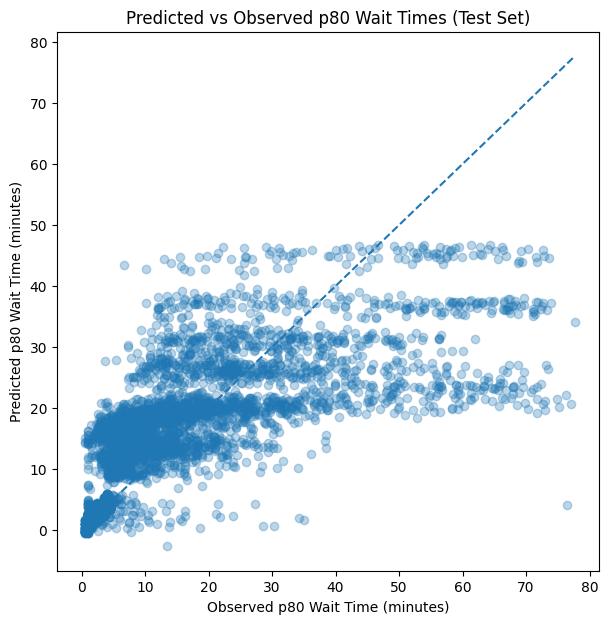

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))

plt.scatter(
    y_test,
    y_pred_lin,
    alpha=0.3
)

# 45-degree reference line
max_val = max(y_test.max(), y_pred_lin.max())
plt.plot([0, max_val], [0, max_val], linestyle="--")

plt.xlabel("Observed p80 Wait Time (minutes)")
plt.ylabel("Predicted p80 Wait Time (minutes)")
plt.title("Predicted vs Observed p80 Wait Times (Test Set)")
plt.show()


### Train a Random Forest model with target-encoded branch identifiers

Fit a nonlinear tree-based model using calendar features, operational context, and leakage-aware target encoding for branch identifiers to capture persistent site-level effects and demand–capacity interactions.

In [ ]:
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

num_features = ["daily_volume", "month", "week_of_year", "dow_sin", "dow_cos"]
ohe_features = ["region", "site_type", "visit_type_mode"]
te_features = ["Branch ID"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("ohe", OneHotEncoder(handle_unknown="ignore"), ohe_features),
        ("te", TargetEncoder(smoothing=30), te_features),
    ]
)

rf_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", RandomForestRegressor(
            n_estimators=300,
            min_samples_leaf=5,
            n_jobs=-1,
            random_state=42
        ))
    ]
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = np.mean(np.abs(y_test - y_pred_rf))

print(f"Test R^2: {r2_rf:.4f}")
print(f"Test MAE:  {mae_rf:.4f}")
print(f"Test RMSE: {rmse_rf:.4f}")

Test R^2: 0.8057
Test MAE:  2.6875
Test RMSE: 5.8585


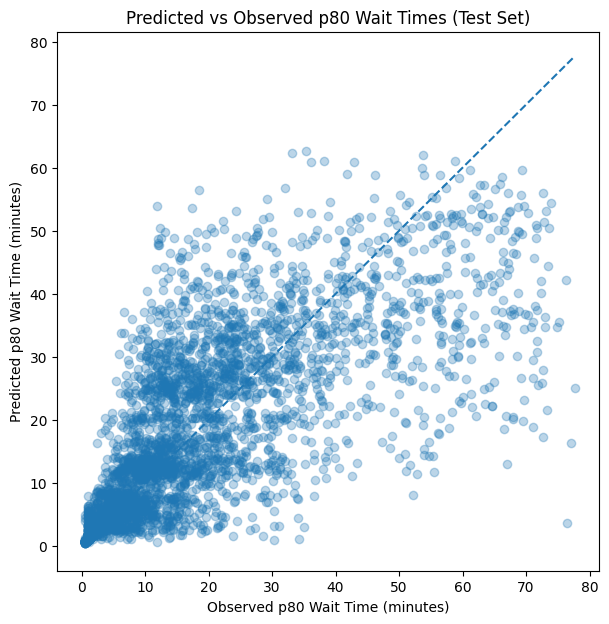

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))

plt.scatter(
    y_test,
    y_pred_rf,
    alpha=0.3
)

# 45-degree reference line
max_val = max(y_test.max(), y_pred_rf.max())
plt.plot([0, max_val], [0, max_val], linestyle="--")

plt.xlabel("Observed p80 Wait Time (minutes)")
plt.ylabel("Predicted p80 Wait Time (minutes)")
plt.title("Predicted vs Observed p80 Wait Times (Test Set)")
plt.show()


### Evaluate feature importance using permutation-based analysis

Assess the relative contribution of each feature to model performance by measuring changes in prediction accuracy when feature values are randomly permuted on the held-out test set.

In [8]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(
    rf_model, 
    X_test, 
    y_test, 
    n_repeats=10, 
    random_state=0
    )

sorted_indices = perm_importance.importances_mean.argsort()[::-1]
for i in sorted_indices:
    print(f"{X.columns[i]}: {perm_importance.importances_mean[i]:.3f} ± {perm_importance.importances_std[i]:.3f}")  

Branch ID: 0.489 ± 0.012
daily_volume: 0.251 ± 0.008
site_type: 0.159 ± 0.009
region: 0.111 ± 0.005
visit_type_mode: 0.085 ± 0.005
dow_sin: 0.014 ± 0.002
week_of_year: 0.004 ± 0.002
dow_cos: 0.002 ± 0.001
max_wickets: -0.000 ± 0.000
month: -0.002 ± 0.000


### Save trained model pipeline  

In [120]:
import joblib

model_path = "../models/rf_wait_time_pipeline.joblib"

joblib.dump(rf_model, model_path)

['../models/rf_wait_time_pipeline.joblib']